# Project : Generating faces to remove mask on photos

In [ ]:
! pip install opencv-python pyunpack scikit-image pillow==5.3.0
%reload_ext autoreload
%autoreload

## I - Dataset

## II - GAN Model

In [10]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F

from pyunpack import Archive
from tensorflow import keras 
from keras.utils.data_utils import Sequence

from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Reshape, Dense, add
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import random, math



In [42]:
masks = [f"./training_set_small/001_Combined_masked/{str(i).rjust(5,'0')}_N95.png" for i in range(2000,4000)]
nomasks = [f"./training_set_small/001_Combined_original/{str(i).rjust(5,'0')}.png" for i in range(2000,4000)]


masks = []
nomasks = []

directory = './converted_256'
parent_dir = os.listdir(directory)
for subdir in parent_dir:   
    if (not os.path.isdir(directory + "/"+ subdir)):
        continue
    is_mask = not subdir.endswith("unmasked")
    # print(len(os.listdir(directory + "/" + subdir)))
    for files in os.listdir(directory + "/" + subdir):
        if (not files.endswith(".png")):
            continue
        if (is_mask):
            masks.append(directory + "/" + subdir  + "/" + files)
        else:
            nomasks.append(directory + "/" + subdir  + "/" + files)
            


In [43]:
print(len(nomasks))
print(len(masks))

9955
9955


In [55]:
class Daugmentation:
    def flip(img, t):
        if t[0]==0:
            return img
        else:
            return cv2.flip(img, t[1])

    def zoom(img, t):
        if t[2]==0:
            return img
        else:
            h, w = img.shape[:2]
            nh, nw =  int(t[3]*h), int(t[3]*w)
            dh, dw = h-nh, w-nw
            zimg = img[dh//2:nh+dh//2, dw//2:nw+dw//2]
            zimg = cv2.resize(zimg, (w,h))
            return zimg


    def get_ts(batch_size):
        return [[random.choice([0,1]),random.choice([-1,0,1]), random.randint(0,2),random.uniform(0.4,0.9)] for i in range(batch_size)]

    def aug(img,t):
        img = Daugmentation.flip(img,t)
        # img = Daugmentation.zoom(img, t)
        return img


class maSequence(Sequence):
    # x and y should store the file location
    def __init__(self, x_set, y_set, batch_size, Daugmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = Daugmentation

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        # get the filename
        batch_x_filename = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_filename = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        

        # load the file
        batch_x, batch_y = [], []
        TARGET_SIZE = 256
        for filename in tqdm(batch_x_filename, desc="loading train_data batch"):
            print('filename' ,filename)
            batch_x.append(np.array(load_img(filename, target_size=(TARGET_SIZE, TARGET_SIZE))))
            
        for filename in tqdm(batch_y_filename, desc="loading train_label batch"):
            batch_y.append(np.array(load_img(filename, target_size=(TARGET_SIZE, TARGET_SIZE))))
        batch_x, batch_y = np.array(batch_x), np.array(batch_y)
        
        ts = self.augment.get_ts(len(batch_x))
        
        return np.array([self.augment.aug(x,t) for x,t in zip(batch_x,ts)]),np.array([self.augment.aug(y,t) for y,t in zip(batch_y,ts)]) 

In [56]:

from tqdm import tqdm
X = []
Y = []
test = []
for i in tqdm(zip(masks, nomasks)):
    # print(i[0])
    try:
        # img = load_img(i[0], target_size=(128,128))
        X.append(i[0])
        # img = load_img(i[1], target_size=(128,128))
        Y.append(i[1])

    except Exception as e: 
        # print(e)
        continue


X = np.array(X)
Y = np.array(Y)
print(len(X),len(Y))
np.random.seed(777)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.1)
x_train.shape,y_train.shape, x_test.shape, y_test.shape


10it [00:00, 34379.54it/s]

10 10


((9,), (9,), (1,), (1,))

In [57]:
# print(torch.tensor(x_train).view(-1,3,128,128).size())

TypeError: Image data of dtype <U47 cannot be converted to float

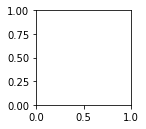

In [58]:
plt.figure(figsize=(20,5))
masks = x_test[:10]
nomasks = y_test[:10]
for i, (x,y) in enumerate(zip(masks[:10],nomasks[:10])):
    plt.subplot(2,10,i+1)
    plt.imshow(x)
    plt.axis("OFF")
    
    plt.subplot(2,10,i+11)
    plt.imshow(y)
    plt.axis("OFF")
plt.show()

In [59]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # First
        
        self.c1_1 = nn.Conv2d(3, 32, kernel_size = 3, padding = "same")
        self.c1_2 = nn.Conv2d(32, 32, kernel_size = 3, padding = "same")
        self.m1 = nn.MaxPool2d(2,2)

        self.c2_1 = nn.Conv2d(32, 64, 3, padding = "same")
        self.c2_2 = nn.Conv2d(64, 64, 3, padding = "same")
        self.m2 = nn.MaxPool2d(2,2)

        self.c3_1 = nn.Conv2d(64, 128, 3, padding = "same")
        self.c3_2 = nn.Conv2d(128, 128, 3, padding = "same")
        self.m3 = nn.MaxPool2d(2,2)

        self.c4_1 = nn.Conv2d(128, 256, 3, padding = "same")
        self.c4_2 = nn.Conv2d(256, 256, 3, padding = "same")


        self.u1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.c5_1 = nn.ConvTranspose2d(128,128, 3, padding = 1)
        self.c5_2 = nn.ConvTranspose2d(128,128, 3, padding = 1)

        self.u2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.c6_1 = nn.ConvTranspose2d(64, 64, 3, padding = 1)
        self.c6_2 = nn.ConvTranspose2d(64, 64, 3, padding = 1)

        self.u3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.c7_1 = nn.ConvTranspose2d(32, 32, 3, padding = 1)
        self.c7_2 = nn.ConvTranspose2d(32, 32, 3, padding = 1)

        self.c8 = nn.Conv2d(32,3,3,padding = 1)
        

    def forward(self, x):
        c1 = self.c1_1(x)
        c1 = F.relu(c1)
        c1 = self.c1_2(c1)
        c1 = F.relu(c1)
        x = self.m1(c1)

        c2 = self.c2_1(x)
        c2 = F.relu(c2)
        c2 = self.c2_2(c2)
        c2 = F.relu(c2)
        x = self.m2(c2)

        c3 = self.c3_1(x)
        c3 = F.relu(c3)
        c3 = self.c3_2(c3)
        c3 = F.relu(c3)
        x = self.m3(c3)

        c4 = self.c4_1(x)
        c4 = F.relu(c4)
        c4 = self.c4_2(c4)
        c4 = F.relu(c4)

        u1 = self.u1(c4)
        u1 = F.pad(u1, (0, 1, 0, 1))
        c5 = self.c5_1(u1)
        c5 = F.relu(c5)
        c5 = self.c5_2(c5)
        c5 = F.relu(c5)

        a1 = torch.add(c5,c3)
        u2 = self.u2(a1)
        u2 = F.pad(u2, (0, 1, 0, 1))
        c6 = self.c6_1(u2)
        c6 = F.relu(c6)
        c6 = self.c6_2(c6)
        c6 = F.relu(c6)

        a2 = torch.add(c6,c2)
        u3 = self.u3(a2)
        u3 = F.pad(u3, (0, 1, 0, 1))
        c7 = self.c7_1(u3)
        c7 = F.relu(c7)
        c7 = self.c7_2(c7)
        c7 = F.relu(c7)

        a3 = torch.add(c7,c1)
        c8 = self.c8(a3)
        output = F.sigmoid(c8)

        return output



In [60]:
import torch
from torch import nn
import random

import torchvision
from torch.utils.data import Dataset, DataLoader

def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device

device = get_device()
device

device(type='cpu')

In [61]:
from torchsummary import summary
net = Generator()
print(net)
summary(net, (3, 128, 128))

ModuleNotFoundError: No module named 'torchsummary'

In [62]:
model = Generator().to(device)
import pytorch_ssim

model.eval()
criterion = pytorch_ssim.SSIM(window_size = 11)
lr = 0.001
optimizer= torch.optim.Adam(model.parameters(), lr=lr)
net = Generator()
batch_size = 16
train_generator = maSequence(x_train, y_train, batch_size, Daugmentation)
test_generator = maSequence(x_test, y_test, batch_size,Daugmentation)

In [63]:
def eval_function():
    
    with torch.no_grad():
            for batch_x, batch_y in test_generator:
                input_image = torch.from_numpy(batch_x).to(torch.float32).to(device)
                target_image = torch.from_numpy(batch_y).to(torch.float32).to(device)
                outputs = model(input_image.view(-1,3,128,128))
                
    
    loss_eval = criterion(outputs, target_image.view(-1,3,128,128))
    return loss_eval.item()


In [64]:
len(train_generator)

1

In [65]:
loss_evolution = []
epochs = []
validate_loss_evolution = []
for epoch in range(1,300):
 
    for i, (batch_x, batch_y) in enumerate(train_generator):
        
        input_image = torch.from_numpy(batch_x).to(torch.float32).to(device)
        target_image = torch.from_numpy(batch_y).to(torch.float32).to(device)
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        outputs = model(input_image.view(-1,3,128,128))
        loss = criterion(outputs, target_image.view(-1,3,128,128))
        loss.backward()
        optimizer.step()
           
    
    if epoch%5 == 0:
        validate_loss = eval_function()
        print("loss = ", loss.item(), " ", "validate_loss = ", validate_loss)
        loss_evolution.append(loss.item())
        validate_loss_evolution.append(validate_loss)
        epochs.append(epoch)
        print(' ')

loading train_data batch: 100%|██████████| 9/9 [00:00<00:00, 135.86it/s]


filename ./converted_256/05000_masked/05827_surgical.png
filename ./converted_256/04000_masked/04007_surgical.png
filename ./converted_256/03000_masked/03877_surgical.png
filename ./converted_256/07000_masked/07221_surgical.png
filename ./converted_256/05000_masked/05692_surgical.png
filename ./converted_256/07000_masked/07650_surgical.png
filename ./converted_256/07000_masked/07380_surgical.png
filename ./converted_256/01000_masked/01073_surgical.png
filename ./converted_256/04000_masked/04369_surgical.png


loading train_label batch: 100%|██████████| 9/9 [00:00<00:00, 156.52it/s]
/Users/yosua.muliawan/miniconda3/envs/deeplearn_course/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/yosua.muliawan/miniconda3/envs/deeplearn_course/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([36, 3, 128, 128]) torch.Size([36, 3, 128, 128]) tensor([[[[1.0576e-06, 7.8144e-06, 3.7022e-05, 1.1246e-04, 2.1905e-04,
           2.7356e-04, 2.1905e-04, 1.1246e-04, 3.7022e-05, 7.8144e-06,
           1.0576e-06],
          [7.8144e-06, 5.7741e-05, 2.7356e-04, 8.3101e-04, 1.6186e-03,
           2.0214e-03, 1.6186e-03, 8.3101e-04, 2.7356e-04, 5.7741e-05,
           7.8144e-06],
          [3.7022e-05, 2.7356e-04, 1.2961e-03, 3.9371e-03, 7.6684e-03,
           9.5766e-03, 7.6684e-03, 3.9371e-03, 1.2961e-03, 2.7356e-04,
           3.7022e-05],
          [1.1246e-04, 8.3101e-04, 3.9371e-03, 1.1960e-02, 2.3294e-02,
           2.9091e-02, 2.3294e-02, 1.1960e-02, 3.9371e-03, 8.3101e-04,
           1.1246e-04],
          [2.1905e-04, 1.6186e-03, 7.6684e-03, 2.3294e-02, 4.5371e-02,
           5.6662e-02, 4.5371e-02, 2.3294e-02, 7.6684e-03, 1.6186e-03,
           2.1905e-04],
          [2.7356e-04, 2.0214e-03, 9.5766e-03, 2.9091e-02, 5.6662e-02,
           7.0762e-02, 5.6662e-02, 2.90

KeyboardInterrupt: 

In [ ]:
torch.save(model, f"./unmask_encoder.pt")

In [8]:
plt.figure(figsize=(20,5))
masks = x_test[:10]
inputs = torch.tensor(masks).view(-1,3,128,128)
device = torch.device('cpu')
inputs = torch.Tensor.cpu(inputs)
model = model.to(device)
nomask_preds = model(inputs).view(-1,128,128,3).detach().numpy()
nomask_actuals = y_test[:10]
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(masks[i])
    plt.axis("OFF")
    
    plt.subplot(3,10,i+11)
    plt.imshow(nomask_preds[i])
    plt.axis("OFF")
    
    plt.subplot(3,10,i+21)
    plt.imshow(nomask_actuals[i])
    plt.axis("OFF")
plt.show()

TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

<Figure size 1440x360 with 0 Axes>

In [9]:
plt.plot(epochs, loss_evolution, label = "loss")
plt.plot(epochs, validate_loss_evolution, label = "validate loss")
plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.show()

NameError: name 'epochs' is not defined